In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import KFold


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

SEED=42
cpu=-1
datasetFolder=os.path.dirname(os.path.dirname(os.getcwd()))

def predict_score(model,x_train,y_train,x_test,y_test,name):
    model.fit(x_train,y_train)
    best_pipe=model.best_estimator_
    poly=best_pipe.named_steps["polynomial_features"]
    poly_features=poly.get_feature_names_out(list(x_train.columns))
    selector=best_pipe.named_steps["feature_selection"]
    select_indices=selector.get_support(1)
    select_features=poly_features[select_indices]
    y_predict=model.predict(x_test)
    f1=f1_score(y_test,y_predict)
    auc_score=roc_auc_score(y_test,y_predict)
    a=1
    return f1,auc_score,select_features
    
def baseDataSet(methodFile):
    df=pd.read_csv(methodFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x',"LongMethod"]]
    x=df.drop(columns="LongMethod")
    y=df[["LongMethod"]]
    return x,y

def addMetricsDataSet(methodFile):
    df=pd.read_csv(methodFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x', 'ATFD_x', 'ATLD_x', 'LAA_x',"LongMethod"]]
    x=df.drop(columns="LongMethod")
    y=df[["LongMethod"]]
    return x,y

def baseVersionDataSet(methodFile):
    df=pd.read_csv(methodFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x','fanin_y', 'fanout_y', 'wmc_y', 'loc_y', 'returnsQty_y', 'variablesQty_y', 'parametersQty_y', 'loopQty_y', 'anonymousClassesQty_y', 'innerClassesQty_y',"LongMethod"]]
    factors=["fanin","fanout","wmc","loc","returnsQty","variablesQty","parametersQty","loopQty","anonymousClassesQty","innerClassesQty"]
    for factor in factors:
        df[factor+"_y"]=df[factor+"_x"]-df[factor+"_y"]
    x=df.drop(columns="LongMethod")
    y=df[["LongMethod"]]
    return x,y

def addMetricsVersionDataSet(methodFile):
    df=pd.read_csv(methodFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x', 'ATFD_x', 'ATLD_x', 'LAA_x',  'fanin_y', 'fanout_y', 'wmc_y', 'loc_y', 'returnsQty_y', 'variablesQty_y', 'parametersQty_y', 'loopQty_y', 'anonymousClassesQty_y', 'innerClassesQty_y', 'ATFD_y', 'ATLD_y', 'LAA_y',"LongMethod"]]
    factors=["fanin","fanout","wmc","loc","returnsQty","variablesQty","parametersQty","loopQty","anonymousClassesQty","innerClassesQty","ATFD","ATLD","LAA"]
    for factor in factors:
        df[factor+"_y"]=df[factor+"_x"]-df[factor+"_y"]
    x=df.drop(columns="LongMethod")
    y=df[["LongMethod"]]
    return x,y



def overSampling(x_train,y_train):
    x_sampling,y_sampling=SMOTE(sampling_strategy=0.2,random_state=SEED).fit_resample(x_train,y_train)
    return x_sampling,y_sampling

def createTrainTestData(x,y):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=SEED)
    x_TrainSampling,y_TrainSampling=overSampling(x_train,y_train)
    return x_TrainSampling,x_test,y_TrainSampling,y_test

In [2]:
LongMethodFile=os.path.join(datasetFolder,"dataset2\\LongMethod.csv")

x_base,y_base=baseDataSet(LongMethodFile)
x_base_train,x_base_test,y_base_train,y_base_test=createTrainTestData(x_base,y_base)
base_score={"f1":[],"auc":[],"feature":[]}

x_add,y_add=addMetricsDataSet(LongMethodFile)
x_add_train,x_add_test,y_add_train,y_add_test=createTrainTestData(x_add,y_add)
add_score={"f1":[],"auc":[],"feature":[]}
print(x_add.head())

x_baseVersion,y_baseVersion=baseVersionDataSet(LongMethodFile)
x_baseVersion_train,x_baseVersion_test,y_baseVersion_train,y_baseVersion_test=createTrainTestData(x_baseVersion,y_baseVersion)
baseVersion_score={"f1":[],"auc":[],"feature":[]}

x_addVersion,y_addVersion=addMetricsVersionDataSet(LongMethodFile)
x_addVersion_train,x_addVersion_test,y_addVersion_train,y_addVersion_test=createTrainTestData(x_addVersion,y_addVersion)
addVersion_score={"f1":[],"auc":[],"feature":[]}


   fanin_x  fanout_x  wmc_x  loc_x  returnsQty_x  variablesQty_x  \
0        2         0      1      3             1               0   
1        2         1      1      3             1               0   
2        1         1      2      7             1               1   
3        0         2      2     10             1               4   
4        1         0      1      3             1               0   

   parametersQty_x  loopQty_x  anonymousClassesQty_x  innerClassesQty_x  \
0                0          0                      0                  0   
1                0          0                      0                  0   
2                1          0                      0                  0   
3                1          0                      0                  0   
4                1          0                      0                  0   

   ATFD_x  ATLD_x  LAA_x  
0     0.0     1.0    1.0  
1     1.0     0.0    0.0  
2     1.0     0.0    0.0  
3     4.0     0.0    0.0  
4    

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


name="KNN"
KNN_prameter={
    'classifier__n_neighbors': range(1, 21, 2),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
    }
KNN=KNeighborsClassifier()

k_range=np.arange(1,11,1)
for i in k_range:
    pipline=Pipeline([
        ("polynomial_features",PolynomialFeatures(degree=2)),
        ("minmaxscaler",MinMaxScaler()),
        ("feature_selection",SelectKBest(score_func=f_classif,k=i)),
        ("classifier",KNeighborsClassifier())
    ])
    model=RandomizedSearchCV(pipline, param_distributions=KNN_prameter,cv=KFold(n_splits=10,shuffle=True,random_state=SEED),random_state=SEED,n_jobs=cpu)
    print(str(i))
    f1_base,auc_base,feature_base=predict_score(model,x_base_train,y_base_train,x_base_test,y_base_test,name)
    base_score["f1"].append(f1_base)
    base_score["auc"].append(auc_base)
    base_score["feature"].append(feature_base)
    
    f1_add,auc_add,feature_add=predict_score(model,x_add_train,y_add_train,x_add_test,y_add_test,name)
    add_score["f1"].append(f1_add)
    add_score["auc"].append(auc_add)
    add_score["feature"].append(feature_add)
    
    f1_baseVersion,auc_baseVersion,feature_baseVersion=predict_score(model,x_baseVersion_train,y_baseVersion_train,x_baseVersion_test,y_baseVersion_test,name)
    baseVersion_score["f1"].append(f1_baseVersion)
    baseVersion_score["auc"].append(auc_baseVersion)
    baseVersion_score["feature"].append(feature_baseVersion)

    f1_addVersion,auc_addVersion,feature_addVersion=predict_score(model,x_addVersion_train,y_addVersion_train,x_addVersion_test,y_addVersion_test,name)
    addVersion_score["f1"].append(f1_addVersion)
    addVersion_score["auc"].append(auc_addVersion)   
    addVersion_score["feature"].append(feature_addVersion)

    #features_baselist.append(baseDF.columns[features_base])
    #features_addlist.append(addMetricsDF.columns[features_add])


1


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

2


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

3


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

4


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

5


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

6


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

7


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

8


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

9


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

10


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFounda

base
f1 :  0.08403361344537816
auc_score :  0.6275663806958371
Index(['dit_x', 'fanin_x', 'fanout_x', 'rfc_x', 'wmc_x'], dtype='object')

addMetrics
f1 :  0.10569105691056911
auc_score :  0.6700273898182312
Index(['dit_x', 'fanout_x', 'rfc_x', 'BOvR_x', 'BUR_x'], dtype='object')

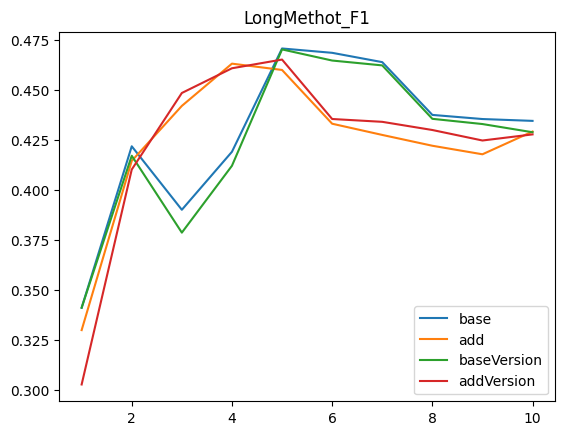

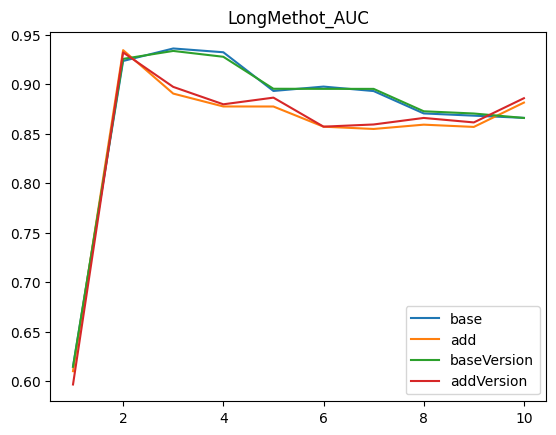

In [4]:
import matplotlib.pyplot as plt

x=k_range
plt.title("LongMethot_F1")
plt.plot(x,base_score["f1"],label="base")
plt.plot(x,add_score["f1"],label="add")
plt.plot(x,baseVersion_score["f1"],label="baseVersion")
plt.plot(x,addVersion_score["f1"],label="addVersion")
plt.legend()
plt.show()

plt.title("LongMethot_AUC")
plt.plot(x,base_score["auc"],label="base")
plt.plot(x,add_score["auc"],label="add")
plt.plot(x,baseVersion_score["auc"],label="baseVersion")
plt.plot(x,addVersion_score["auc"],label="addVersion")
plt.legend()
plt.show()

In [5]:
print("base : ",base_score)
print("add : ",add_score)
print("baseVersion : ",baseVersion_score)
print("addVersion : ",addVersion_score)

base :  {'f1': [0.3411371237458194, 0.42175360710321863, 0.3900497512437811, 0.4190064794816415, 0.47058823529411764, 0.46842105263157896, 0.463768115942029, 0.43741765480895917, 0.43535620052770446, 0.43443708609271525], 'auc': [0.6146327427329125, 0.9235622462923596, 0.9362008379238983, 0.9323837720409455, 0.8932716753893434, 0.8976869021507894, 0.8931734698719789, 0.8705616696063977, 0.8683094173541454, 0.866075020650505], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x'

base :  {'f1': [0.3411371237458194, 0.42175360710321863, 0.3900497512437811, 0.4190064794816415, 0.47058823529411764, 0.46842105263157896, 0.463768115942029, 0.43741765480895917, 0.43535620052770446, 0.43443708609271525], 'auc': [0.6146327427329125, 0.9235622462923596, 0.9362008379238983, 0.9323837720409455, 0.8932716753893434, 0.8976869021507894, 0.8931734698719789, 0.8705616696063977, 0.8683094173541454, 0.866075020650505], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'wmc_x parametersQty_x', 'loc_x parametersQty_x',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x loopQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'fanout_x loc_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x loopQty_x'], dtype=object)]}
add :  {'f1': [0.32996632996632996, 0.41445270988310307, 0.44191919191919193, 0.46301369863013697, 0.4598639455782313, 0.4330175913396482, 0.4274193548387097, 0.42201834862385323, 0.4177545691906005, 0.42910915934755334], 'auc': [0.6101282382284078, 0.9345110354529156, 0.8906176732933273, 0.8776041151409423, 0.8775594762694129, 0.8571731449331663, 0.854867326035079, 0.8592200583763837, 0.856932095026908, 0.8815283143155654], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'loc_x parametersQty_x',
       'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object)]}
baseVersion :  {'f1': [0.3411371237458194, 0.4170305676855895, 0.3786407766990291, 0.41201716738197425, 0.4701195219123506, 0.4645669291338583, 0.4621409921671018, 0.43546284224250326, 0.43285528031290743, 0.4287581699346405], 'auc': [0.6146327427329125, 0.9256895097043297, 0.9337164635396936, 0.9278078453419941, 0.8954882165443723, 0.8954078665756195, 0.8953721554783961, 0.8727514274385089, 0.8704902474119508, 0.8659857429074463], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'wmc_x parametersQty_x', 'loc_x parametersQty_x',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x loopQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'fanout_x loc_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x loopQty_x'], dtype=object)]}
addVersion :  {'f1': [0.3028169014084507, 0.41014799154334036, 0.44836272040302266, 0.46070460704607047, 0.4650537634408602, 0.43537414965986393, 0.4339622641509434, 0.42988204456094364, 0.42463958060288337, 0.4276885043263288], 'auc': [0.5966772191350354, 0.9322052165548281, 0.8973833578243898, 0.8797938729730534, 0.8865238464068926, 0.8572088560303899, 0.8594075416368068, 0.8660035984560581, 0.8614812384029419, 0.8859435410770113], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'loc_x parametersQty_x',
       'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object)]}


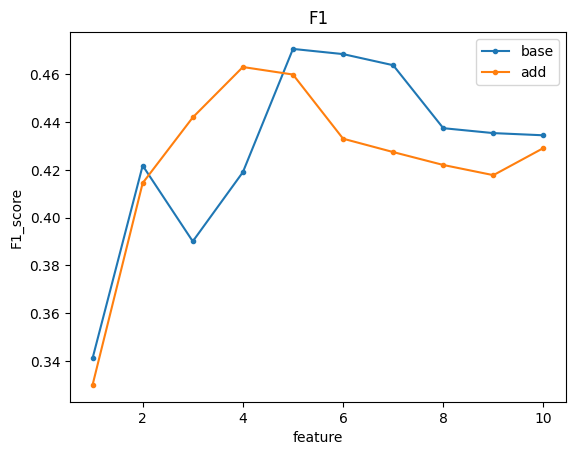

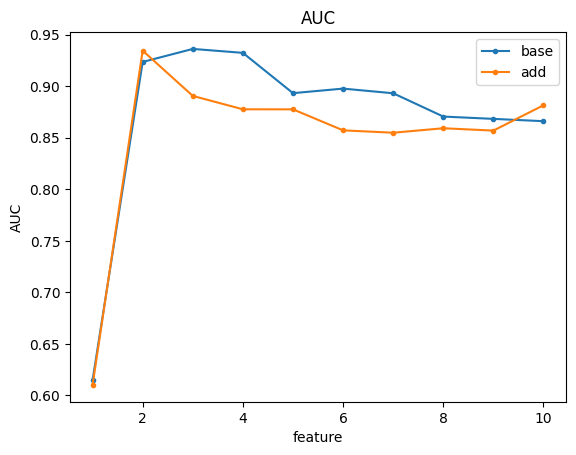

In [1]:
import numpy as np
import matplotlib.pyplot as plt
base_score={'f1': [0.3411371237458194, 0.42175360710321863, 0.3900497512437811, 0.4190064794816415, 0.47058823529411764, 0.46842105263157896, 0.463768115942029, 0.43741765480895917, 0.43535620052770446, 0.43443708609271525], 'auc': [0.6146327427329125, 0.9235622462923596, 0.9362008379238983, 0.9323837720409455, 0.8932716753893434, 0.8976869021507894, 0.8931734698719789, 0.8705616696063977, 0.8683094173541454, 0.866075020650505]}
add_score={'f1': [0.32996632996632996, 0.41445270988310307, 0.44191919191919193, 0.46301369863013697, 0.4598639455782313, 0.4330175913396482, 0.4274193548387097, 0.42201834862385323, 0.4177545691906005, 0.42910915934755334], 'auc': [0.6101282382284078, 0.9345110354529156, 0.8906176732933273, 0.8776041151409423, 0.8775594762694129, 0.8571731449331663, 0.854867326035079, 0.8592200583763837, 0.856932095026908, 0.8815283143155654]}
baseVersion_score={'f1': [0.3411371237458194, 0.4170305676855895, 0.3786407766990291, 0.41201716738197425, 0.4701195219123506, 0.4645669291338583, 0.4621409921671018, 0.43546284224250326, 0.43285528031290743, 0.4287581699346405], 'auc': [0.6146327427329125, 0.9256895097043297, 0.9337164635396936, 0.9278078453419941, 0.8954882165443723, 0.8954078665756195, 0.8953721554783961, 0.8727514274385089, 0.8704902474119508, 0.8659857429074463]}
addVersion_score={'f1': [0.3028169014084507, 0.41014799154334036, 0.44836272040302266, 0.46070460704607047, 0.4650537634408602, 0.43537414965986393, 0.4339622641509434, 0.42988204456094364, 0.42463958060288337, 0.4276885043263288], 'auc': [0.5966772191350354, 0.9322052165548281, 0.8973833578243898, 0.8797938729730534, 0.8865238464068926, 0.8572088560303899, 0.8594075416368068, 0.8660035984560581, 0.8614812384029419, 0.8859435410770113]}
x=np.arange(1,11,1)
plt.title("F1")
plt.xlabel("feature")
plt.ylabel("F1_score")
plt.plot(x,base_score["f1"],label="base",marker=".")
plt.plot(x,add_score["f1"],label="add",marker=".")
#plt.plot(x,baseVersion_score["f1"],label="baseVersion",linestyle="dashed",marker="v")
#plt.plot(x,addVersion_score["f1"],label="addVersion",linestyle="dashed",marker="v")
plt.legend()
plt.show()

plt.title("AUC")
plt.xlabel("feature")
plt.ylabel("AUC")
plt.plot(x,base_score["auc"],label="base",marker=".")
plt.plot(x,add_score["auc"],label="add",marker=".")
#plt.plot(x,baseVersion_score["auc"],label="baseVersion",linestyle="dashed",marker="v")
#plt.plot(x,addVersion_score["auc"],label="addVersion",linestyle="dashdot",marker="v")
plt.legend()
plt.show()

f1
base :  0.47058823529411764
add :  0.4598639455782313
baseVersion :  0.4701195219123506
auc
base :  0.8932716753893434
add :  0.8775594762694129
baseVersion :  0.8954882165443723
feature
base :  ['wmc_x' 'loc_x' 'variablesQty_x' 'loopQty_x' 'loc_x parametersQty_x']
add :  ['loc_x' 'variablesQty_x' 'ATFD_x' 'loc_x parametersQty_x' 'ATFD_x LAA_x']
baseVersion :  ['wmc_x' 'loc_x' 'variablesQty_x' 'loopQty_x' 'loc_x parametersQty_x']


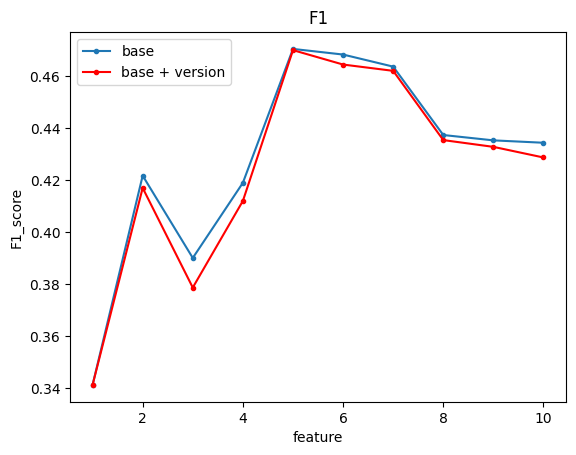

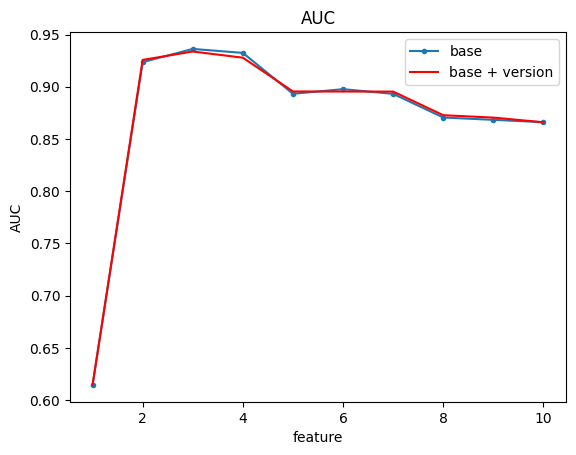

In [ ]:
from numpy import array
import numpy as np
import matplotlib.pyplot as plt

base1_score={'f1': [0.3411371237458194, 0.42175360710321863, 0.3900497512437811, 0.4190064794816415, 0.47058823529411764, 0.46842105263157896, 0.463768115942029, 0.43741765480895917, 0.43535620052770446, 0.43443708609271525], 'auc': [0.6146327427329125, 0.9235622462923596, 0.9362008379238983, 0.9323837720409455, 0.8932716753893434, 0.8976869021507894, 0.8931734698719789, 0.8705616696063977, 0.8683094173541454, 0.866075020650505], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'wmc_x parametersQty_x', 'loc_x parametersQty_x',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x loopQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'fanout_x loc_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x loopQty_x'], dtype=object)]}
add1_score=  {'f1': [0.32996632996632996, 0.41445270988310307, 0.44191919191919193, 0.46301369863013697, 0.4598639455782313, 0.4330175913396482, 0.4274193548387097, 0.42201834862385323, 0.4177545691906005, 0.42910915934755334], 'auc': [0.6101282382284078, 0.9345110354529156, 0.8906176732933273, 0.8776041151409423, 0.8775594762694129, 0.8571731449331663, 0.854867326035079, 0.8592200583763837, 0.856932095026908, 0.8815283143155654], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'loc_x parametersQty_x',
       'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object)]}
baseVersion1_score={'f1': [0.3411371237458194, 0.4170305676855895, 0.3786407766990291, 0.41201716738197425, 0.4701195219123506, 0.4645669291338583, 0.4621409921671018, 0.43546284224250326, 0.43285528031290743, 0.4287581699346405], 'auc': [0.6146327427329125, 0.9256895097043297, 0.9337164635396936, 0.9278078453419941, 0.8954882165443723, 0.8954078665756195, 0.8953721554783961, 0.8727514274385089, 0.8704902474119508, 0.8659857429074463], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'wmc_x parametersQty_x', 'loc_x parametersQty_x',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x loopQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'fanout_x loc_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x loopQty_x'], dtype=object)]}
addVersion1_score=  {'f1': [0.3028169014084507, 0.41014799154334036, 0.44836272040302266, 0.46070460704607047, 0.4650537634408602, 0.43537414965986393, 0.4339622641509434, 0.42988204456094364, 0.42463958060288337, 0.4276885043263288], 'auc': [0.5966772191350354, 0.9322052165548281, 0.8973833578243898, 0.8797938729730534, 0.8865238464068926, 0.8572088560303899, 0.8594075416368068, 0.8660035984560581, 0.8614812384029419, 0.8859435410770113], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'loc_x parametersQty_x',
       'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object)]}


factors=["f1","auc","feature"]
for factor in factors:
    print(factor)
    print("base : ",base1_score[factor][4])
    print("add : ",add1_score[factor][4])
    print("baseVersion : ",baseVersion1_score[factor][4])
     
x=np.arange(1,11,1)
plt.title("F1")
plt.xlabel("feature")
plt.ylabel("F1_score")
plt.plot(x,base1_score["f1"],label="base",marker=".")
#plt.plot(x,add1_score["f1"],label="add",marker=".")
plt.plot(x,baseVersion1_score["f1"],label="base + version",marker=".",color="red")
#plt.plot(x,addVersion1_score["f1"],label="addVersion",linestyle="dashed",marker="v")
plt.legend()
plt.show()

plt.title("AUC")
plt.xlabel("feature")
plt.ylabel("AUC")
plt.plot(x,base1_score["auc"],label="base",marker=".")
#plt.plot(x,add_score["auc"],label="add",marker=".")
plt.plot(x,baseVersion1_score["auc"],label="base + version",color="red")
#plt.plot(x,addVersion1_score["auc"],label="addVersion",linestyle="dashdot",marker="v")
plt.legend()
plt.show()